In [55]:
import numpy as np
import tensorflow as tf


In [56]:
def conv_block(inputs,n_filters,n_conv):
    output = inputs
    for i in range(n_conv):
        output = tf.layers.conv2d(inputs=output,filters=n_filters,kernel_size=[3,3],padding='same',activation=tf.nn.relu)
    output = tf.layers.max_pooling2d(inputs=output,pool_size=[2,2],strides=2)
    return output

In [57]:
def model(features,labels,mode,params):
    x = features['x']
    for n_filters,n_conv in params['network_def']:
        x = conv_block(x,n_filters,n_conv)
    x = tf.reshape(x,[-1,params['flat_size']])
    x = tf.layers.dense(inputs=x,units=params['fc1'],activation=tf.nn.relu)
    x = tf.layers.dropout(inputs=x,rate=0.4,training=(mode==tf.estimator.ModeKeys.TRAIN))
    x = tf.layers.dense(inputs=x,units=params['fc2'],activation=tf.nn.relu)
    logits = tf.layers.dense(inputs=x,units=params['n_classes'],activation=None)
    
    
    
    predictions = {
        'classes' : tf.argmax(logits,axis=1),
        'probabilities' : tf.nn.softmax(logits)
    }
    
    eval_ops = {
        'accuracy' : tf.metrics.accuracy(labels=labels,predictions=predictions['classes'])
    }
    
    tf.summary.scalar('accuracy',eval_ops['accuracy'][1])
    
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(predictions=predictions,mode=mode)
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels,logits=logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=params['learning_rate'])
        train_op = optimizer.minimize(loss=loss,global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode,loss=loss,train_op=train_op)
    

    return tf.estimator.EstimatorSpec(mode=mode,loss=loss,eval_metric_ops=eval_ops)

def vgg_block(inputs,n_filters,dr,n_conv,lmd,mode):
    output = inputs
    for i in range(n_conv):
        output = tf.layers.conv2d(inputs=output,filters=n_filters,kernel_size=[3,3],padding='same',activation=tf.nn.relu,kernel_regularizer=tf.contrib.layers.l2_regularizer(lmd))
        output = tf.layers.batch_normalization(inputs=output,training=(mode==tf.estimator.ModeKeys.TRAIN))
        if i != n_conv-1:
            output = tf.layers.dropout(inputs=output,rate=dr,training=(mode==tf.estimator.ModeKeys.TRAIN))
    output = tf.layers.max_pooling2d(inputs=output,pool_size=[2,2],strides=2)
    return output

def vgg_net(features,labels,mode,params):
    x = features['x']
    for n_filters,n_conv,dr in params['network_def']:
        x = vgg_block(x,n_filters,dr,n_conv,params['regulariser'],mode)
    x = tf.layers.dropout(inputs=x,rate=0.5,training=(mode==tf.estimator.ModeKeys.TRAIN))
    x = tf.reshape(x,[-1,params['flat_size']])
    x = tf.layers.dense(inputs=x,units=params['fc1'],activation=tf.nn.relu,kernel_regularizer=tf.contrib.layers.l2_regularizer(params['regulariser']))
    x = tf.layers.batch_normalization(inputs=x,training=(mode==tf.estimator.ModeKeys.TRAIN))
    x = tf.layers.dropout(inputs=x,rate=0.5,training=(mode==tf.estimator.ModeKeys.TRAIN))
    
    logits = tf.layers.dense(inputs=x,units=params['n_classes'],activation=None)
        
    predictions = {
        'classes' : tf.argmax(logits,axis=1),
        'probabilities' : tf.nn.softmax(logits)
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(predictions=predictions,mode=mode)
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels,logits=logits)

    if mode == tf.estimator.ModeKeys.TRAIN:
        global_step = tf.train.get_global_step()
        learning_rate = tf.train.exponential_decay(params['learning_rate'],global_step,128 * params['lr_drop'],0.5,staircase=True)
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss=loss,global_step=global_step)
        return tf.estimator.EstimatorSpec(mode=mode,loss=loss,train_op=train_op)
    
    eval_ops = {
        'accuracy' : tf.metrics.accuracy(labels=labels,predictions=predictions['classes'])
    }
    return tf.estimator.EstimatorSpec(mode=mode,loss=loss,eval_metric_ops=eval_ops)
  
    
    

In [58]:
params = {
    'network_def' : [(64,2,0.3),(128,2,0.4),(256,3,0.4),(512,3,0.4),(512,3,0.4)],
    'flat_size' : 512,
    'fc1' : 512,
    'n_classes' : 10,
    'learning_rate' : 0.01,
    'lr_drop' : 20,
    'regulariser' : 0.0005
}
vgg19 = tf.estimator.Estimator(model_fn=vgg_net,params=params,model_dir='VGG16')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_log_step_count_steps': 100, '_service': None, '_num_ps_replicas': 0, '_save_checkpoints_steps': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe20385ffd0>, '_num_worker_replicas': 1, '_model_dir': 'VGG16', '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_keep_checkpoint_every_n_hours': 10000, '_master': '', '_is_chief': True, '_task_id': 0, '_task_type': 'worker', '_tf_random_seed': None, '_keep_checkpoint_max': 5, '_session_config': None}


In [59]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.cifar10.load_data()
x_train = np.asarray(x_train,dtype=np.float32)
x_test = np.asarray(x_test,dtype=np.float32)
y_train = np.asarray(y_train,dtype=np.int32)
y_test = np.asarray(y_test,dtype=np.int32)
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train - mean)/(std + 1e-7)
x_test = (x_test - mean)/(std + 1e-7)
x_test.shape

(10000, 32, 32, 3)

In [6]:
train_input = tf.estimator.inputs.numpy_input_fn(x={'x' : x_train},y=y_train,batch_size=128,num_epochs=None,shuffle=True)
vgg19.train(input_fn=train_input,steps=19200)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from VGG16/model.ckpt-12800
INFO:tensorflow:Saving checkpoints for 12801 into VGG16/model.ckpt.
INFO:tensorflow:step = 12801, loss = 0.0818135
INFO:tensorflow:global_step/sec: 16.647
INFO:tensorflow:step = 12901, loss = 0.059433132 (6.009 sec)
INFO:tensorflow:global_step/sec: 17.8082
INFO:tensorflow:step = 13001, loss = 0.08927066 (5.616 sec)
INFO:tensorflow:global_step/sec: 17.7781
INFO:tensorflow:step = 13101, loss = 0.14664131 (5.624 sec)
INFO:tensorflow:global_step/sec: 17.7513
INFO:tensorflow:step = 13201, loss = 0.056533836 (5.634 sec)
INFO:tensorflow:global_step/sec: 17.706
INFO:tensorflow:step = 13301, loss = 0.092452936 (5.648 sec)
INFO:tensorflow:global_step/sec: 17.6978
INFO:tensorflow:step = 13401, loss = 0.06705346 (5.650 sec)
INFO:tensorflow:global_step/sec: 17.6114
INFO:tensorflow:step = 13501, loss = 0.06714876 (5.678 sec)
INFO:tensorflow:global_step/sec: 17.5392
INFO:tensorflow:step = 1360

In [60]:
eval_input = tf.estimator.inputs.numpy_input_fn(x={'x' : x_test},y=y_test,num_epochs=1,shuffle=False)
eval_results = vgg19.evaluate(input_fn=eval_input)
print(eval_results)

INFO:tensorflow:Starting evaluation at 2018-06-22-16:31:03
INFO:tensorflow:Restoring parameters from VGG16/model.ckpt-32000
INFO:tensorflow:Finished evaluation at 2018-06-22-16:31:05
INFO:tensorflow:Saving dict for global step 32000: accuracy = 0.8844, global_step = 32000, loss = 0.55136216
{'global_step': 32000, 'loss': 0.55136216, 'accuracy': 0.8844}


/users/btech/yatind/Image_cptning2018/env3/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  


INFO:tensorflow:Restoring parameters from VGG16/model.ckpt-32000
frog
Classification is accurate


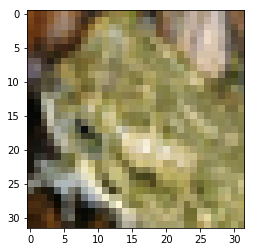

In [63]:
import matplotlib.pyplot as plt
from random import randint
from scipy.misc import toimage
num = randint(0,10000-1)
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
plt.imshow(toimage(x_test[num] * (std + 1e-7) + mean))
img = np.reshape(x_test[num],(1,32,32,3))
pred_fn = tf.estimator.inputs.numpy_input_fn({'x' : img},shuffle=False)
pred_res = vgg19.predict(input_fn=pred_fn)
result = next(pred_res)['classes']
print(classes[result])
if result == y_test[num]:
    print('Classification is accurate')
else:
    print('Classification is inaccurate')